In [ ]:
from google.colab import drive


drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import typing
import os
import pandas as pd
import numpy as np

from torch import nn, Tensor
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torchvision.models import resnet18
from torchsummary import summary

from sklearn.model_selection import train_test_split

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    torch.cuda.set_device(current_device)
    device = torch.device(f'cuda:{current_device}')
    print(f'Using GPU: {torch.cuda.get_device_name(current_device)}')
else:
    device = torch.device('cpu') 

Using GPU: Tesla P4


In [ ]:
data_dir = '/content/gdrive/MyDrive/data'

os.chdir(data_dir)
print('current dir:', os.getcwd())

current dir: /content/gdrive/MyDrive/data


In [ ]:
try:
    train_df = pd.read_csv('./digit-recognizer/train.csv')
    test_df = pd.read_csv('./digit-recognizer/test.csv')
except Exception as err:
    print(str(err))

In [ ]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y = train_df.label.values
X = train_df.iloc[:, train_df.columns != 'label'].values / 255
X_test = test_df.values / 255

print('X.shape =', X.shape, ', X.ndim =', X.ndim)
print('Y.shape =', Y.shape, ', Y.ndim =', Y.ndim)
print('X_test.shape =', X_test.shape, ', X_test.ndim =', X_test.ndim)

X.shape = (42000, 784) , X.ndim = 2
Y.shape = (42000,) , Y.ndim = 1
X_test.shape = (28000, 784) , X_test.ndim = 2


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1, 
                                                  random_state=42)

print('train_x.shape =', train_x.shape, ', train_x.ndim =', train_x.ndim)
print('val_x.shape =', val_x.shape, ', val_x.ndim =', val_x.ndim)
print('train_y.shape =', train_y.shape, ', train_y.ndim =', train_y.ndim)
print('val_y.shape =', val_y.shape, ', val_y.ndim =', val_y.ndim)

train_x.shape = (37800, 784) , train_x.ndim = 2
val_x.shape = (4200, 784) , val_x.ndim = 2
train_y.shape = (37800,) , train_y.ndim = 1
val_y.shape = (4200,) , val_y.ndim = 1


In [ ]:
trainTorch_x = torch.from_numpy(train_x).type(torch.FloatTensor)
trainTorch_y = torch.from_numpy(train_y).type(torch.LongTensor)

valTorch_x = torch.from_numpy(val_x).type(torch.FloatTensor)
valTorch_y = torch.from_numpy(val_y).type(torch.LongTensor)

testTorch_x = torch.from_numpy(np.array(X_test)).type(torch.FloatTensor)

In [ ]:
train = torch.utils.data.TensorDataset(trainTorch_x, trainTorch_y)
val = torch.utils.data.TensorDataset(valTorch_x, valTorch_y)
test = torch.utils.data.TensorDataset(testTorch_x)

In [ ]:
train_loader = DataLoader(train, batch_size=128, shuffle=False)
val_loader = DataLoader(val, batch_size=16, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

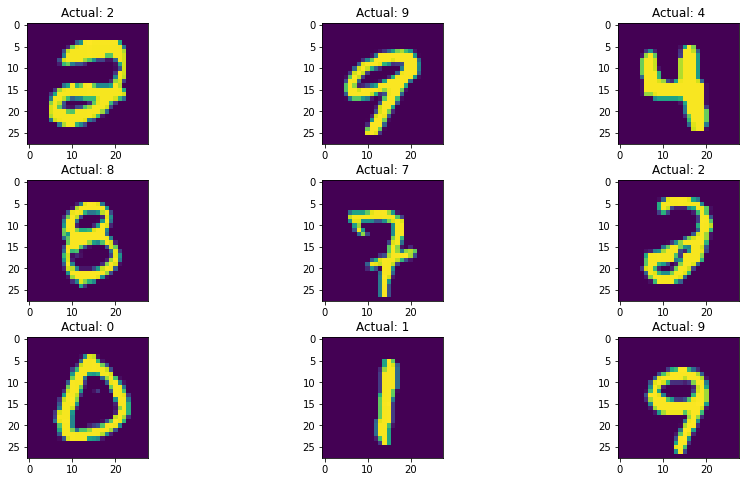

In [ ]:
randomlist = []
for i in range(0, 9):
    n = random.randint(0, len(X))
    randomlist.append(n)

fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(3, 3)
axs = []

for num in range(len(randomlist)):
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].imshow(X[randomlist[num]].reshape(28, 28))
    axs[-1].set_title("Actual: " + str(Y[randomlist[num]]))
fig.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, in_channels=1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, 
                               padding=3, bias=False)
        self.resnet = resnet18(pretrained=True)
        self.classifier = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

if torch.cuda.is_available():
    print("Model will be training on GPU")
    model = Resnet18().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
else:
    input = torch.randn((16, 1, 244, 244))
    model = Resnet18(i)
    criterion = nn.CrossEntropyLoss()
    print("Model will be training on CPU")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 0.0002)

Model will be training on GPU


In [ ]:
summary(model, input_size=(1, 28, 28))

RuntimeError: ignored

In [ ]:
model.train()
n_iterations = 0
print_every = 50
steps = 0
train_losses, val_losses = [], []
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        steps += 1
        data, target = Variable(images.view(128, 1, 28, 28)), Variable(labels)
        output = model(data)
        if torch.cuda.is_available():
            data = data.to(device)
            target = target.to(device)
            output = output.to(device)
        optimizer.zero_grad()
        model.zero_grad()
        loss = criterion(output, target)

        n_iterations += 1

        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if step % print_every == 0:
            val_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in val_loader:
                    data, target = Variable(images.view(16, 3, 28, 28), 
                                            volatile=True), Variable(labels)

                    if torch.cuda.is_available():
                        data = data.to(device)
                        target = target.to(device)

                    log_ps = model(data)
                    loss = criterion(log_ps, target)
                    val_loss += loss.item()

                    ps = torch.exp(log_ps)

                    top_p, top_class - ps.topk(1, dim=1)
                    equals = top_class == target.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.cuda.FloatTensor))

            model.train()

            train_losses.append(running_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))

    print(f'Epoch: {epoch + 1}/{num_epochs}, Training Loss: {val_losses[-1]:.5f}, Val Loss: {val_losses[-1]:.5f}, Val Accuracy: {accuracy/len(val_loader):.5f}')

RuntimeError: ignored

In [ ]:
!